In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import os
import random
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

os.chdir("../")
from Src.Tools import *

### Loading Commodities data

In [2]:
# Crude Oil : CL=F
# Natural Gas : NG=F
# Gold : GC=F
# Silver : SI=F
# Copper : HG=F
# S&P 500 : ^GSPC
# Dow Jones : ^DJI

ticker = "GC=F"
start = "2010-01-01"
end = "2024-01-01"
interval = "1d"

data = yf.download(ticker, start=start, end=end, interval=interval)
data.columns = data.columns.droplevel(1)  

# Ajoutons RSI et EMA au DataFrame
data["RSI"] = compute_rsi(data["Close"], period=14)
data["EMA12"] = compute_ema(data["Close"], period=12)
data.dropna(inplace=True)

print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open  Volume  \
Date                                                                     
2010-01-04  1117.699951  1122.300049  1097.099976  1117.699951     184   
2010-01-05  1118.099976  1126.500000  1115.000000  1118.099976      53   
2010-01-06  1135.900024  1139.199951  1120.699951  1135.900024     363   
2010-01-07  1133.099976  1133.099976  1129.199951  1133.099976      56   
2010-01-08  1138.199951  1138.199951  1122.699951  1138.199951      54   

Price             RSI        EMA12  
Date                                
2010-01-04  36.944392  1117.699951  
2010-01-05  36.944392  1117.761493  
2010-01-06  36.944392  1120.552037  
2010-01-07  36.944392  1122.482489  
2010-01-08  36.944392  1124.900560  



c:\Users\planc\Personnel\CentraleSupélec\Reinforcement_learning\Trading_bot_Reinforcement_learning\Src\Tools.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')


c:\Users\planc\anaconda3\envs\env_rl_project\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


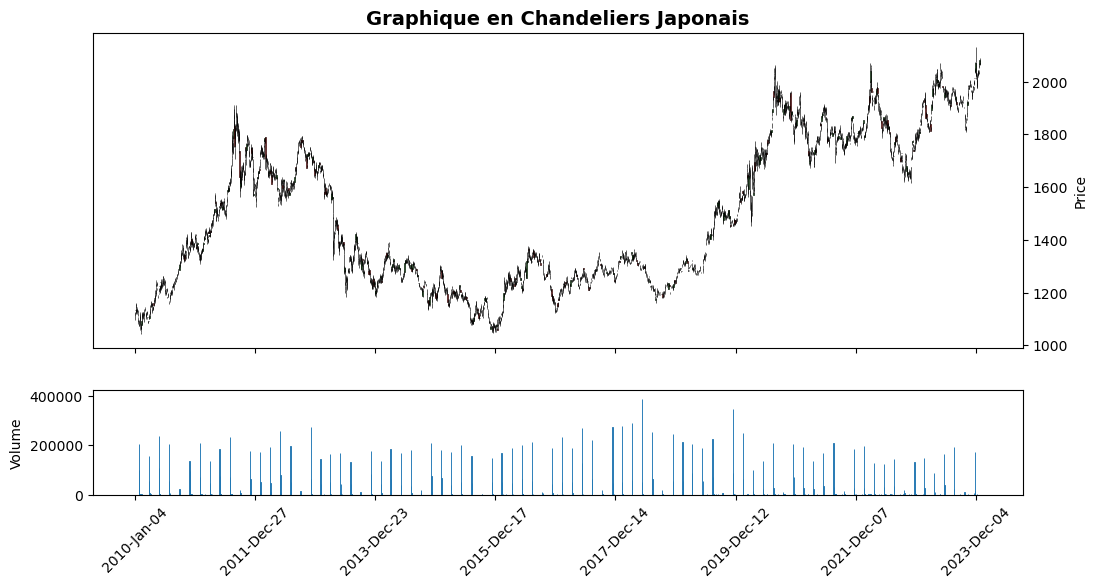

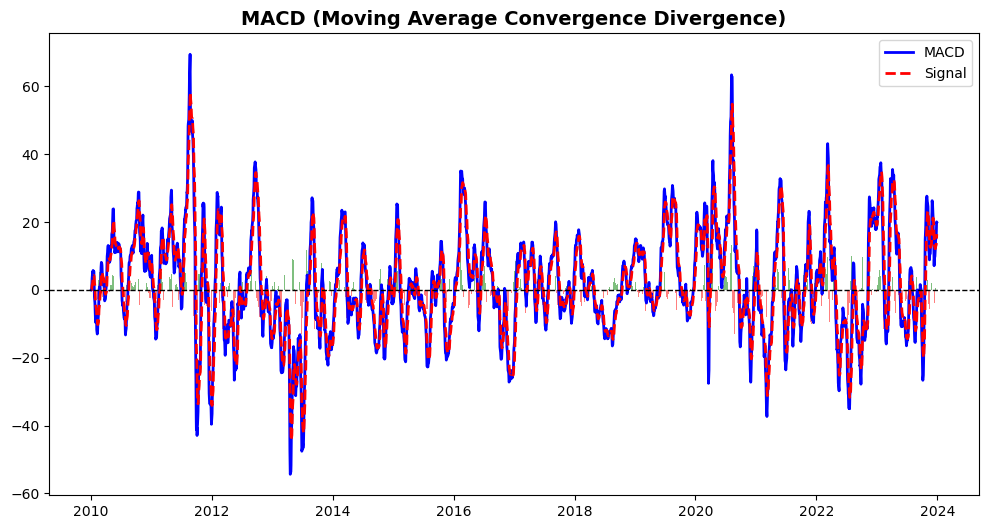

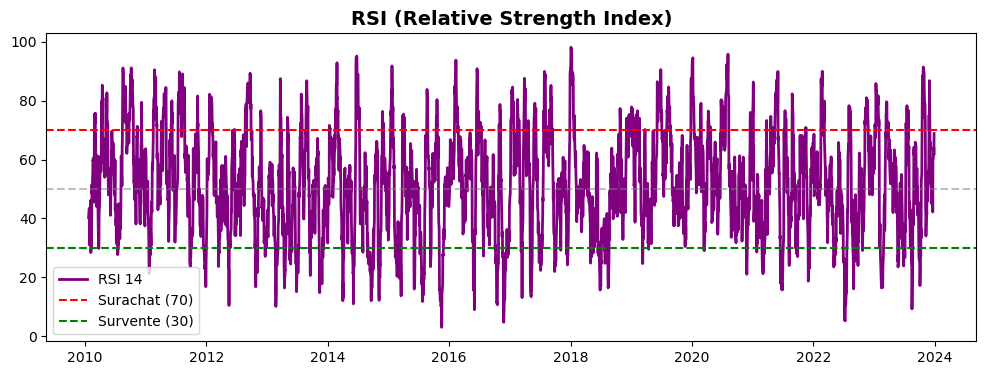

In [32]:
plot_candlestick(data)
plot_macd(data)
plot_rsi(data)

### Designing Environnement

In [35]:
class Environment:
    """
    Environnement simplifié de trading sur l'or.
    - Actions discrètes : 0=stay, 1=buy, 2=sell
    - On maintient une liste des positions ouvertes, on calcule le profit
      lorsque l'on vend (2), etc.
      
    Variables description:
    - self.df : DataFrame avec les données historiques
    - self.history_t : taille de la fenêtre historique
    - self.features : liste des colonnes à utiliser
    - self.t : indice temporel actuel
    - self.done : booléen, True si la simulation est terminée
    - self.profits : gains cumulés
    - self.positions : liste des positions ouvertes (prix d'achat pas encore cloturé)
    - self.position_value : valeur actuelle des positions ouvertes. Il s'agit du gain ou la perte potentielle si l agent vendait 
                            immédiatement toutes ses positions ouvertes.
    - self.history : liste des variations de prix (Close_t - Close_t-1) sur les derniers jours (pour l'observation)
    -obs : observation actuelle (position_value, history..., Close(t), RSI(t), EMA12(t))
    -reward : récompense pour l'action précédente
    """

    def __init__(self, df, history_t=30):
        """
        :param df: DataFrame avec colonnes ['Open','High','Low','Close','RSI','EMA12']
        :param history_t: taille de la fenêtre historique
        """
        self.df = df.copy().reset_index(drop=True)
        self.history_t = history_t
        self.features = ["Close", "RSI", "EMA12"]
        self.reset()

    def reset(self):
        """
        Remet l'environnement à zéro :
         - t = 0
         - profits = 0
         - positions = []
         - position_value = 0
         - history -> [0]*history_t
        """
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0.0] * self.history_t

        return self._get_obs()

    def _get_obs(self):
        """
        Construit l'observation : 
        [position_value, history..., Close(t), RSI(t), EMA12(t)]
        """
        row = self.df.iloc[self.t]
        feats = [
            float(row["Close"]),
            float(row["RSI"]) if not pd.isnull(row["RSI"]) else 0.0,  # Correction ici
            float(row["EMA12"])
        ]
        obs = [self.position_value] + self.history + feats
        return np.array(obs, dtype=np.float32)


    def step(self, act):
        """
        Exécute l'action (0=stay,1=buy,2=sell).
        Retourne : obs, reward, done
        """
        reward_raw = 0.0
        reward = 0
        fee_rate = 0.001

        # Exécution
        if act == 1:
            # buy
            self.positions.append(self.df.iloc[self.t]["Close"])
        elif act == 2:
            # sell
            if len(self.positions) == 0:
                reward_raw = -1.0  # Pénalité si on vend sans position
            else:
                # Gains cumulés
                profits = 0.0
                current_price = self.df.iloc[self.t]["Close"]
                for p in self.positions:
                    profits += (current_price - p)
                # Calcul des frais pour toutes les positions
                transaction_cost = fee_rate * current_price * len(self.positions)
                profits -= transaction_cost
                reward_raw = profits
                self.profits += profits
                self.positions = []  # On ferme toutes les positions

        # Avancer dans le temps
        self.t += 1
        if self.t >= len(self.df) - 1:
            self.done = True

        # Calcul de la position latente
        self.position_value = 0.0
        if len(self.positions) > 0:
            current_price = self.df.iloc[self.t]["Close"]
            for p in self.positions:
                self.position_value += (current_price - p)

        # Mettre à jour l'historique
        if self.t > 0:
            price_diff = self.df.iloc[self.t]["Close"] - self.df.iloc[self.t - 1]["Close"]
        else:
            price_diff = 0.0
        self.history.pop(0)
        self.history.append(price_diff)

        # Reward final (clip)
        if reward_raw > 0:
            reward = 1.0
        elif reward_raw < 0:
            reward = -1.0
        else:
            reward = 0.0

        return self._get_obs(), reward, self.done, reward_raw
    
    def update_data(self, new_df):
        """
        Met à jour les données de l'environnement sans recréer l'objet.
        """
        self.df = new_df.copy()
        self.t = self.history_t  # On commence à history_t pour avoir une fenêtre complète
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0.0] * self.history_t

### Designing Agent

In [4]:
class QLearningTrader:
    """
    Met en place un DQN simple en PyTorch pour entraîner un agent
    sur l'environnement GoldTradingEnv.
    """

    # --- Le réseau de neurones ---
    class QNetwork(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    def __init__(
        self,
        env: Environment,
        hidden_dim=64,
        gamma=0.95,
        lr=1e-3,
        memory_size=200,
        batch_size=32,
        eps_start=1.0,
        eps_min=0.1,
        eps_decay=1e-3,
        update_target_freq=50,
        train_freq=10
    ):
        """
        :param env: Environnement (Environment)
        :param hidden_dim: taille des couches cachées
        :param gamma: discount factor
        :param lr: learning rate pour Adam
        :param memory_size: taille du buffer d'expérience
        :param batch_size: taille du batch
        :param eps_start, eps_min, eps_decay: pour l'epsilon-greedy
        :param update_target_freq: fréquence de copie du réseau principal vers le réseau cible
        :param train_freq: fréquence d'entraînement (en nombre de steps)
        """
        self.env = env
        sample_obs = self.env.reset()
        self.input_dim = len(sample_obs)
        self.hidden_dim = hidden_dim
        self.output_dim = 3  # stay, buy, sell -> 0, 1, 2

        self.gamma = gamma
        self.lr = lr
        self.memory_size = memory_size
        self.batch_size = batch_size

        self.eps = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.update_target_freq = update_target_freq
        self.train_freq = train_freq

        # Réseaux
        self.policy_net = self.QNetwork(self.input_dim, hidden_dim, self.output_dim)
        self.target_net = copy.deepcopy(self.policy_net)

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Mémoire de replay : [(pobs, act, reward, obs, done), ...]
        self.memory = []
        self.total_steps = 0

    def select_action(self, obs):
        """
        Sélection d'action via epsilon-greedy.
        """
        if random.random() < self.eps:
            return random.randint(0, self.output_dim - 1)
        obs_t = torch.FloatTensor(obs).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.policy_net(obs_t)
        return q_vals.argmax(dim=1).item()

    def update_epsilon(self):
        """
        Baisse epsilon linéairement jusqu'à eps_min.
        """
        if self.eps > self.eps_min:
            self.eps -= self.eps_decay
            if self.eps < self.eps_min:
                self.eps = self.eps_min

    def store_transition(self, pobs, act, reward, obs, done):
        """
        Stocke la transition dans le buffer.
        """
        self.memory.append((pobs, act, reward, obs, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)

    def train_step(self):
        """
        Un pas d'entraînement : on échantillonne un batch, on calcule la loss,
        et on met à jour policy_net.
        """
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        pobs, acts, rewards, obs_, dones = zip(*batch)
        pobs_t = torch.FloatTensor(pobs)
        acts_t = torch.LongTensor(acts)
        rewards_t = torch.FloatTensor(rewards)
        obs_t = torch.FloatTensor(obs_)
        dones_t = torch.BoolTensor(dones)

        # Q(s, a) du réseau policy_net
        q_vals = self.policy_net(pobs_t)
        # On ne prend que la Q-valeur de l'action réelle
        q_val = q_vals.gather(1, acts_t.unsqueeze(1)).squeeze(1)

        # Q-target : r + gamma * max(Q') (avec target_net)
        with torch.no_grad():
            q_next = self.target_net(obs_t)
            q_next_max, _ = q_next.max(dim=1)
            q_target = rewards_t + (self.gamma * q_next_max * (~dones_t))

        loss = nn.MSELoss()(q_val, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target(self):
        """
        Copie policy_net -> target_net
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def train(self, epochs=10):
        """
        Boucle d'entraînement sur un certain nombre d'épisodes (epochs).
        """
        step_max = len(self.env.df) - 1
        show_log_freq = max(1, epochs // 5)

        rewards_history = []
        rewards_raw_history = []
        losses_history = []

        # Stocke les profits nets journaliers
        daily_profits = {}

        start_time = time.time()
        for epoch in range(epochs):
            obs = self.env.reset()
            done = False
            ep_reward = 0.0
            ep_reward_raw = 0.0
            ep_loss = 0.0
            step = 0

            # Initialiser la date actuelle et la liste des profits nets du jour
            current_date = self.env.t
            daily_profits[current_date] = []

            while not done and step < step_max:
                act = self.select_action(obs)
                next_obs, reward, done, reward_raw = self.env.step(act)

                # Enregistrer le profit net du trade dans la date correspondante
                trade_date = self.env.t
                if trade_date not in daily_profits:
                    daily_profits[trade_date] = []
                daily_profits[trade_date].append(reward_raw)

                ep_reward += reward
                ep_reward_raw += reward_raw

                self.store_transition(obs, act, reward, next_obs, done)

                # Entraînement
                if self.total_steps % self.train_freq == 0:
                    loss_val = self.train_step()
                    ep_loss += loss_val

                # Update target network
                if self.total_steps % self.update_target_freq == 0:
                    self.update_target()

                # Décroissance de epsilon
                self.update_epsilon()

                obs = next_obs
                self.total_steps += 1
                step += 1

            rewards_history.append(ep_reward)
            rewards_raw_history.append(ep_reward_raw)
            losses_history.append(ep_loss)

            # Logging
            if (epoch + 1) % show_log_freq == 0:
                avg_r = np.mean(rewards_history[-show_log_freq:])
                avg_l = np.mean(losses_history[-show_log_freq:])
                elapsed = time.time() - start_time
                print(f"[Epoch {epoch+1}] Eps={self.eps:.3f}, Steps={self.total_steps}, "
                      f"Avg.Reward={avg_r:.2f}, Avg.Loss={avg_l:.3f}, Time={elapsed:.2f}s")
                start_time = time.time()

        # Calculer R_port^t après l'entraînement
        
        R_port = {date: np.mean(profits) if len(profits) > 0 else 0 for date, profits in daily_profits.items()}

        return rewards_history, rewards_raw_history, losses_history, R_port

## Test Agent Performances

### Training

In [33]:
data_train, data_test = train_test_split(data, random_state=42, test_size=0.3)

# Création de l'environnement
env_train = Environment(data_train, history_t=30)
# Instanciation du trader
trader = QLearningTrader(
    env_train,
    hidden_dim=64,
    gamma=0.95,
    lr=1e-3,
    memory_size=500,
    batch_size=32,
    eps_start=1.0,
    eps_min=0.1,
    eps_decay=1e-3,
    update_target_freq=50,
    train_freq=10
)
# Entraînement sur X épisodes
rewards, rewards_raw, losses, R_port = trader.train(epochs=300)

print("=== Entraînement terminé ===")
print("Proft final :", trader.env.profits)

[Epoch 60] Eps=0.100, Steps=147720, Avg.Reward=165.55, Avg.Loss=2631.156, Time=35.58s
[Epoch 120] Eps=0.100, Steps=295440, Avg.Reward=598.27, Avg.Loss=34.693, Time=36.35s
[Epoch 180] Eps=0.100, Steps=443160, Avg.Reward=637.63, Avg.Loss=26.783, Time=35.35s
[Epoch 240] Eps=0.100, Steps=590880, Avg.Reward=635.32, Avg.Loss=24.978, Time=36.22s
[Epoch 300] Eps=0.100, Steps=738600, Avg.Reward=636.27, Avg.Loss=23.818, Time=37.39s
=== Entraînement terminé ===
Proft final : 416100.4697362063


In [34]:
# Train
profits_train = list(R_port.values())  # C'est la liste cumulative des profits du test

# Calcul des métriques
metrics = calculate_metrics(profits_train)

# Affichage des résultats
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

E(R): 17.3807
std(R): 107.6126
Downside Deviation (DD): 3.7635
Sharpe Ratio: 0.1615
Sortino Ratio: 4.6182
MDD: nan
Calmar Ratio: nan
% +ve Returns: 53.7556
Ave. P / Ave. L: 24.2686


c:\Users\planc\Personnel\CentraleSupélec\Reinforcement_learning\Trading_bot_Reinforcement_learning\Src\Tools.py:124: RuntimeWarning: divide by zero encountered in divide
  drawdowns = (cumulative_returns - running_max) / running_max
c:\Users\planc\Personnel\CentraleSupélec\Reinforcement_learning\Trading_bot_Reinforcement_learning\Src\Tools.py:124: RuntimeWarning: invalid value encountered in divide
  drawdowns = (cumulative_returns - running_max) / running_max


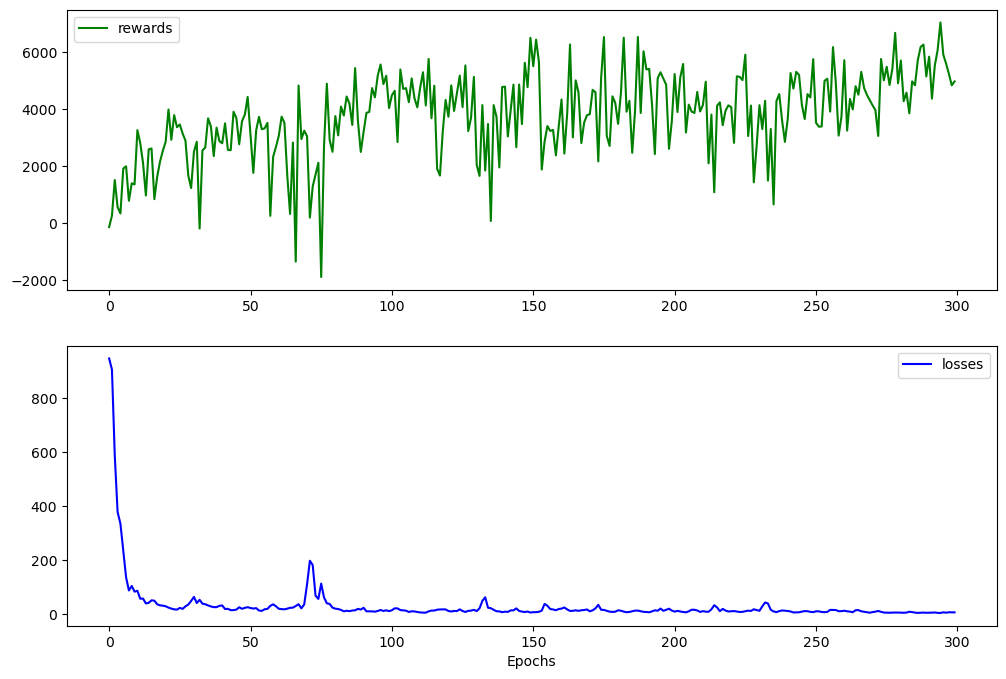

In [12]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(rewards_raw, label="rewards", color="green")
plt.legend()

plt.subplot(2,1,2)
plt.plot(losses, label="losses", color="blue")

plt.xlabel("Epochs")
plt.legend()
plt.show()

### Test

In [26]:
# Tester l'agent sur un environnement non vu (data_test)
env_test = Environment(data_test, history_t=30)
obs = env_test.reset()
done = False
total_profit = 0
total_raw_profit = 0
actions_taken = []
rewards_test = []
rewards_raw_test = []

R_port_test = {}  # Dictionnaire des rendements par période
current_date = env_test.t  # Date actuelle dans les données
daily_profits = []  # Liste des profits par jour

while not done:
    action = trader.select_action(obs)  # Utilisation du modèle appris
    obs, reward, done, reward_raw = env_test.step(action)

    total_profit += reward
    total_raw_profit += reward_raw
    rewards_test += [total_profit]
    rewards_raw_test += [total_raw_profit]
    actions_taken.append(action)

    # Obtenir la date actuelle
    new_date = env_test.t

    # Vérifier si on change de jour
    if new_date != current_date:
        if daily_profits:  # Si des trades ont été faits sur cette période
            R_port_test[current_date] = np.mean(daily_profits)  # Moyenne des profits par période
        daily_profits = []  # Réinitialiser la liste
        current_date = new_date  # Mettre à jour la date

    # Ajouter le profit du trade en cours
    daily_profits.append(reward_raw)

# Ajouter la dernière période
if daily_profits:
    R_port_test[current_date] = np.mean(daily_profits)

print(f"Reward total sur données test : {total_profit}")
print(f"Actions prises : {actions_taken}")
print(f"Profit final : {env_test.profits}")

Reward total sur données test : -15.0
Actions prises : [2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 0, 2, 0]
Profit final : 135.32314880371098


In [27]:
# Test
profits_test = list(R_port_test.values())  # C'est la liste cumulative des profits du test

# Calcul des métriques
metrics = calculate_metrics(profits_test)

# Affichage des résultats
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

E(R): 5.3991
std(R): 40.3757
Downside Deviation (DD): 44.9728
Sharpe Ratio: 0.1337
Sortino Ratio: 0.1201
MDD: -0.6785
Calmar Ratio: 7.9569
% +ve Returns: 5.4054
Ave. P / Ave. L: 9.0990


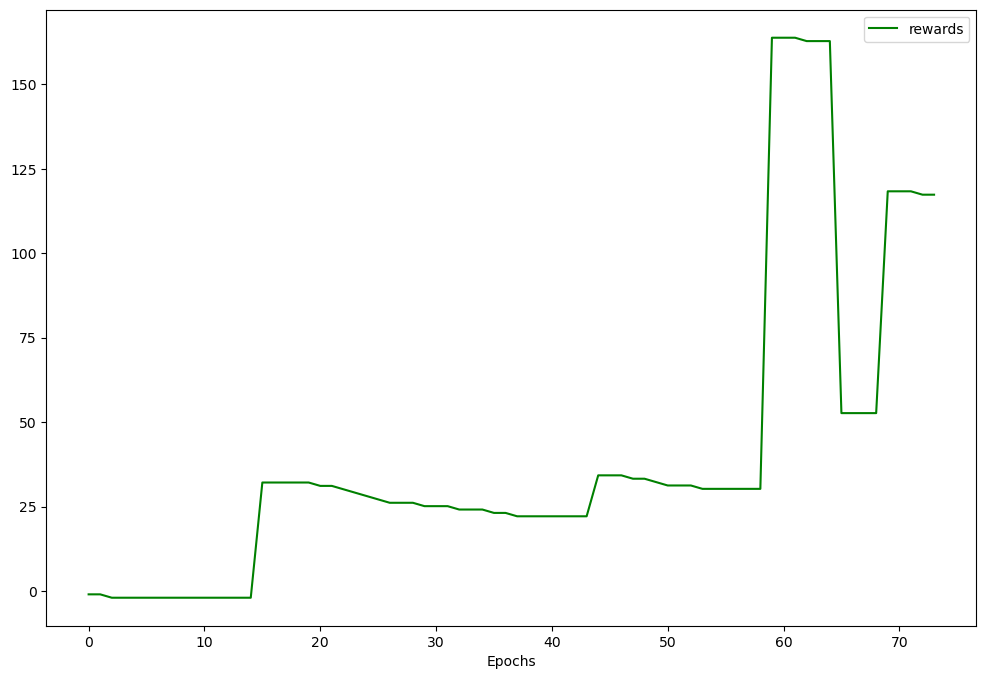

In [28]:
plt.figure(figsize=(12,8))
plt.plot(rewards_raw_test, label="rewards", color="green")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [36]:
# Paramètres
train_years = 5  # 5 ans d'entraînement
test_years = 5   # 5 ans de test

# Convertir les indices en années
data["Year"] = data.index.year  # Assurez-vous que votre index est un DateTimeIndex
years = sorted(data["Year"].unique())

# Initialiser une seule fois l'agent avec les premières données d'entraînement
first_train_data = data[(data["Year"] >= years[0]) & (data["Year"] <= years[train_years - 1])]
env_train = Environment(first_train_data, history_t=30)
trader = QLearningTrader(env_train)  # Création du modèle une seule fois

# Boucle sur les périodes glissantes
results = []
for i in range(len(years) - train_years - test_years + 1):
    train_start = years[i]
    train_end = years[i + train_years - 1]
    test_start = years[i + train_years]
    test_end = years[i + train_years + test_years - 1]

    print(f"Période {train_start}-{train_end} (train) → {test_start}-{test_end} (test)")

    # Création des datasets
    data_train = data[(data["Year"] >= train_start) & (data["Year"] <= train_end)]
    data_test = data[(data["Year"] >= test_start) & (data["Year"] <= test_end)]

    # Màj de l'environnement
    if i > 0:
        env_train.update_data(data_train)

    # Entraînement du modèle
    trader.train(epochs=50)  # Ajuste le nombre d'epochs

    # Test du modèle sur les 5 années suivantes
    env_test = Environment(data_test, history_t=30)
    obs = env_test.reset()
    done = False
    total_profit = 0
    total_raw_profit = 0
    rewards_raw = []
    actions_taken = []
    
    R_port = {}  # Stocker les rendements moyens

    while not done:
        action = trader.select_action(obs)
        obs, reward, done, reward_raw = env_test.step(action)
        rewards_raw += [reward_raw]
        total_profit += reward
        total_raw_profit += reward_raw
        actions_taken.append(action)

        # Calculer Rt_port pour chaque période
        current_year = env_test.df.iloc[env_test.t]["Year"]
        if current_year not in R_port:
            R_port[current_year] = []
        R_port[current_year].append(reward_raw)

    # Moyenne annuelle des rendements
    for year in R_port:
        R_port[year] = np.mean(R_port[year])

    results.append({"train_period": (train_start, train_end), 
                    "test_period": (test_start, test_end),
                    "final_profit": total_profit, 
                    "final_raw_profit": total_raw_profit,
                    "rewards_raw": rewards_raw,
                    "R_port": R_port})

Période 2010-2014 (train) → 2015-2019 (test)
[Epoch 10] Eps=0.100, Steps=12570, Avg.Reward=-82.20, Avg.Loss=961.053, Time=3.01s
[Epoch 20] Eps=0.100, Steps=25140, Avg.Reward=-57.00, Avg.Loss=177.111, Time=3.04s
[Epoch 30] Eps=0.100, Steps=37710, Avg.Reward=-37.50, Avg.Loss=26.318, Time=3.05s
[Epoch 40] Eps=0.100, Steps=50280, Avg.Reward=-45.00, Avg.Loss=29.885, Time=3.01s
[Epoch 50] Eps=0.100, Steps=62850, Avg.Reward=-68.40, Avg.Loss=118.091, Time=3.03s
Période 2011-2015 (train) → 2016-2020 (test)
[Epoch 10] Eps=0.100, Steps=75420, Avg.Reward=-38.90, Avg.Loss=64.320, Time=3.33s
[Epoch 20] Eps=0.100, Steps=87990, Avg.Reward=-42.60, Avg.Loss=34.650, Time=3.31s
[Epoch 30] Eps=0.100, Steps=100560, Avg.Reward=-28.30, Avg.Loss=18.440, Time=3.28s
[Epoch 40] Eps=0.100, Steps=113130, Avg.Reward=-11.50, Avg.Loss=15.861, Time=3.28s
[Epoch 50] Eps=0.100, Steps=125700, Avg.Reward=-14.70, Avg.Loss=33.682, Time=3.29s
Période 2012-2016 (train) → 2017-2021 (test)
[Epoch 10] Eps=0.100, Steps=138250, Avg

In [37]:
# Extraire R_port sous forme d'une simple liste
R_port_list = [r for res in results for r in res["R_port"].values()]

metrics = calculate_metrics(R_port_list)

# Affichage des résultats
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

E(R): 60.9909
std(R): 45.8191
Downside Deviation (DD): 3.2626
Sharpe Ratio: 1.3311
Sortino Ratio: 18.6938
MDD: -0.2605
Calmar Ratio: 234.1116
% +ve Returns: 76.0000
Ave. P / Ave. L: 5.1546


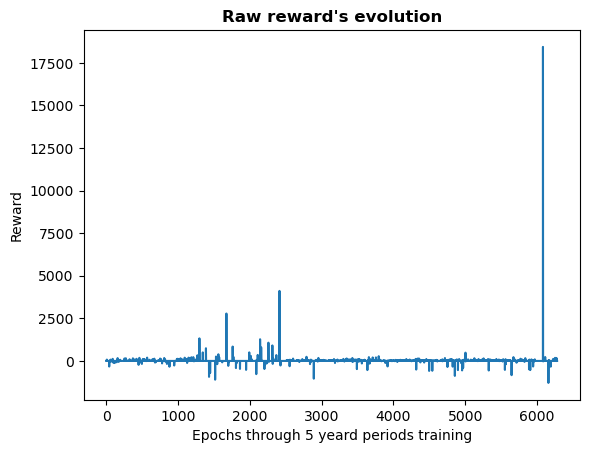

In [38]:
rewards_raw_list = [r for res in results for r in res["rewards_raw"]]
plt.plot(rewards_raw_list)

plt.xlabel("Epochs through 5 yeard periods training")
plt.ylabel("Reward")
plt.title("Raw reward's evolution", weight="bold")
plt.show()

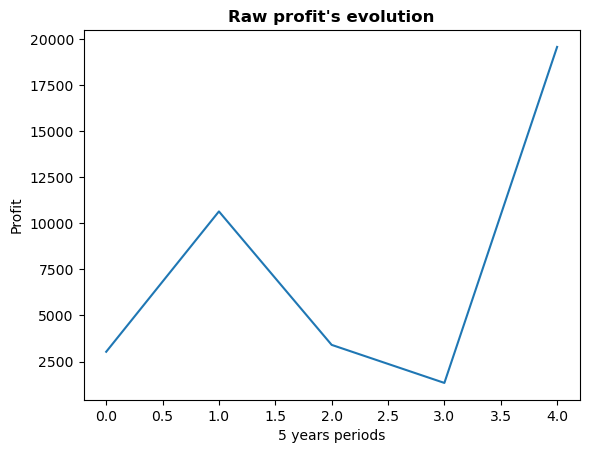

In [39]:
profits_raw_list = [d["final_raw_profit"] for d in results if "final_raw_profit" in d]
plt.plot(profits_raw_list)

plt.xlabel("5 years periods")
plt.ylabel("Profit")
plt.title("Raw profit's evolution", weight="bold")
plt.show()

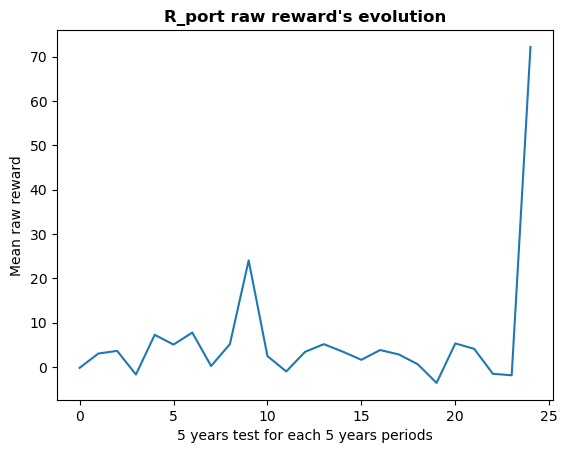

In [40]:
plt.plot(R_port_list)

plt.xlabel("5 years test for each 5 years periods")
plt.ylabel("Mean raw reward")
plt.title("R_port raw reward's evolution", weight="bold")
plt.show()